# Bias detection using distributional models using the Maltese language

## 0. Table of Contents

**1. Pre-requisites:** must be run every time  
**2. Load Corpus:** only if training  
**3. Train models:** only if training  
**4. Test models:** for testing saved models 

## 1. Pre-requisites

Import all required libraries

In [1]:
from gensim.models.keyedvectors import KeyedVectors
from debiaswe.we import WordEmbedding
from utils.weat import calculate_bias
from gensim.models import TfidfModel
from utils.callback import callback
from gensim.models import FastText
from gensim.models import Word2Vec
import sklearn.feature_extraction
from utils.plot import plotBias
import matplotlib.pyplot as plt
from numpy.linalg import norm
from debiaswe import debias
from gensim import corpora
import sklearn.naive_bayes
import gensim.downloader
from debiaswe import we
import sklearn.datasets
import sklearn.manifold
import sklearn.metrics
import numpy as np
import gensim
import random
import pickle
import scipy
import json
import nltk
import math
import re


## 2. Load Corpus

`load_traditional` $\rightarrow$ load corpus document by document  
`load_modern` $\rightarrow$ load corpus token by token

In [ ]:
data = []
documents = []

load_traditional = False
load_modern = True

for file in os.listdir("../dataset/dataset-neutral"):

    with open(f"../dataset/dataset-neutral/{file}", "r", encoding="utf8") as f:
        text = f.read()

    if load_traditional:
        document = re.sub('[^a-zA-Z ]+', "", text)
        documents.append(document) 
    elif load_modern:
        sentences = nltk.tokenize.sent_tokenize(text)
        for sentence in sentences:
            tokens = nltk.tokenize.word_tokenize(sentence)
            tokens = [token for token in tokens if re.match('^[a-zA-Z]+$', token)]
            data.append(tokens)

    print(f"Finished with {file}!")


## 3. Train models

### 3.1. Training Word2Vec

In [ ]:
word2vec_model = Word2Vec(
    data,
    size=100,
    window=10,
    min_count=2,
    workers=10
)

# Train the model
word2vec_model.train(data, total_examples=len(data), epochs=10, compute_loss=True, callbacks=[callback()])

# Save the model and embedding for later use.
word2vec_model.save('../saved/neutral/word2vec/word2vec.model')
word2vec_model.wv.save_word2vec_format('../saved/neutral/word2vec/word2vec_embedding.bin', binary=True)

### 3.2. Training FastText

In [ ]:
fasttext_model = FastText(
    data, 
    size=100, 
    window=10, 
    min_count=2, 
    workers=10
)

fasttext_model.train(data, total_examples=len(data), epochs=10)

fasttext_model.save('../saved/neutral/fasttext/fasttext.model')

### 3.3. Fitting TF-IDF Vectorizer

In [ ]:
tfidf_featuriser = sklearn.feature_extraction.text.TfidfVectorizer(stop_words=None)
tfidf_featuriser.fit(documents)
tfidf_docterm_matrix = tfidf_featuriser.transform(documents)

pickle.dump(tfidf_featuriser, open("../saved/tfidf_vectorizer/tfidf_featuriser.pickle", "wb"))
pickle.dump(tfidf_docterm_matrix, open("../saved/tfidf_vectorizer/tfidf_docterm_matrix.pickle", "wb"))

## 4. Test models
### 4.1. Test word2vec or FastText

In [2]:
mode = "original"
name = "word2vec"

E = WordEmbedding(f"../saved/{mode}/{name}/{name}.model")

*** Reading data from ../saved/original/word2vec/word2vec.model
(321253, 100)
321253 words of dimension 100 : li, u, ta, ma, ..., zeelie, ballboys, omoroo, comission
321253 words of dimension 100 : li, u, ta, ma, ..., zeelie, ballboys, omoroo, comission


Get gender direction $\overrightarrow{g}$...

In [3]:
with open(f"../saved/s0.json", "r") as f:
    s0 = json.load(f)
g = we.doPCA(s0, E).components_[0]

Get pairs in $Male:Female$ format ...

In [4]:
name = "s1"

with open(f"../saved/{name}.json", "r") as f:
    key_words = json.load(f)
    print("Loaded maltese pairs...")

male = [p[0] for p in key_words]
female = [p[1] for p in key_words]

Loaded maltese pairs...


$O_1$: Calculate and visualise $|b_i|$ for every profession...

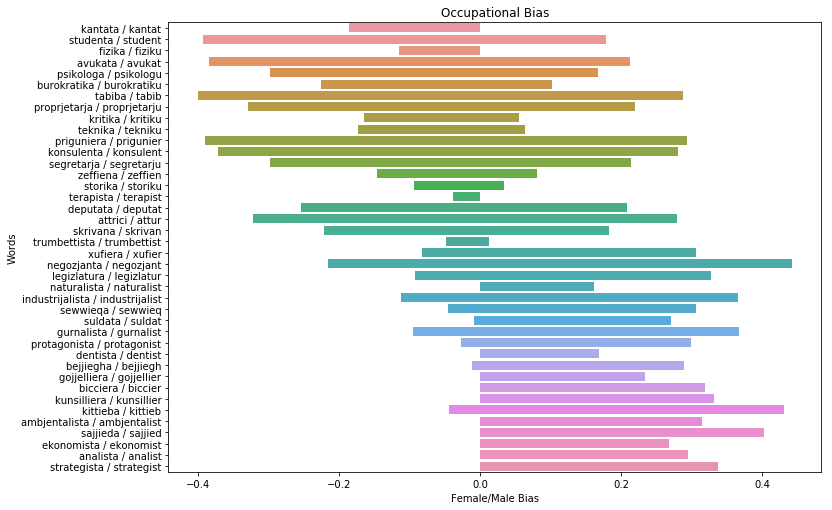

In [5]:
mb = {}
fb = {}
b = []

for i, w in enumerate(key_words):
    male = w[0]
    female = w[1]

    try:
        mb[male] = E.v(male).dot(g)
        fb[female] = E.v(female).dot(g)
    except KeyError:
        continue

    total_bias = mb[male] + fb[female]
    b.append([female, male, total_bias])

b = sorted(b, key=lambda x: x[2])
extremes = b[0:20] + b[-20:]

plotBias(mb, fb, extremes, title="Occupational Bias")

$O_2$: Use the $WEAT$ metric to quantify bias

In [6]:
M = [x[0] for x in s0]
F = [x[1] for x in s0]
bias = calculate_bias(E, M, F, key_words)

avg_bias = np.array([bias[k] for k in bias]).mean()

print(f"Average bias: {avg_bias}")
print("Top 20 biased terms according to the WEAT metric...")
dict(sorted(bias.items(), key=lambda x: x[1], reverse=True)[0:20])


Average bias: 0.5901237221640057
Top 20 biased terms according to the WEAT metric...


{'kittieb / kittieba': 1.7792585892602801,
 'sajjied / sajjieda': 1.691115309484303,
 'kunsillier / kunsilliera': 1.3931380780413747,
 'biccier / bicciera': 1.298558382783085,
 'bejjiegh / bejjiegha': 1.298442978411913,
 'sewwieq / sewwieqa': 1.2898861863650382,
 'protagonist / protagonista': 1.2893242777790874,
 'suldat / suldata': 1.2443326376378536,
 'gurnalist / gurnalista': 1.1826376840472221,
 'industrijalist / industrijalista': 1.171829713974148,
 'xufier / xufiera': 1.0805516266264021,
 'negozjant / negozjanta': 1.052805830258876,
 'kummentatur / kummentatrici': 1.0227440153248608,
 'legizlatur / legizlatura': 1.0196296951035038,
 'student / studenta': 0.9970996398478746,
 'ambjentalist / ambjentalista': 0.9847206722479314,
 'furnar / furnara': 0.9739903155714273,
 'gwerrier / gwerriera': 0.9599693920463324,
 'antropologu / antropologa': 0.9087334163486958,
 'qattiel / qattiela': 0.8791019646450877}

Hard debias word embedding given gender direction $\overrightarrow{g}$, $E$ (equality sets) and $G$ (gender-specific words)...

In [3]:
with open('../saved/equality_sets.json', "r") as f:
    e = json.load(f)

with open('../saved/gender_specific.json', "r") as f:
    G = json.load(f)

debias.debias(E, G, g, e, we)

NameError: name 'g' is not defined

Generate best analogies...

In [7]:
a_gender = E.best_analogies_dist_thresh(g, topn=500, max_words=10000)

for (a,b,c) in a_gender:
    print(a+"-"+b)

Computing neighbors
Mean: 33.8608
Median: 22.0
missier-omm
tieghu-taghha
missieru-ommha
kantant-kantanta
uliedu-uliedha
anzjan-anzjana
hajtu-hajjitha
ibnu-bintha
mar-marret
telaq-telqet
rega-regghet
missieri-ommi
mieghu-maghha
jibqa-tibqa
joqghod-toqghod
tifel-tifla
naghtuh-naghtuha
idejh-idejha
spicca-spiccat
jaghtuh-jaghtuha
ammetta-ammettiet
kellux-kellhiex
jaqla-taqla
iservi-isservi
gurnalist-gurnalista
ghajnejh-ghajnejha
jikteb-tikteb
igib-iggib
jigbor-tigbor
hadem-hadmet
qalbu-qalbha
ragel-mara
jgholli-tgholli
jiftah-tiftah
jkollux-jkollhiex
qabad-qabdet
itejjeb-ittejjeb
jevita-tevita
wiccu-wiccha
donnu-donnha
jmur-tmur
jitlaq-titlaq
jircievi-tircievi
jispicca-tispicca
isahhah-issahhah
warajh-warajha
jbigh-tbigh
ghalliem-studenta
rasu-rasha
idur-iddur
jibdel-tibdel
fetah-fethet
jaghtih-taghtiha
jistudja-tistudja
johrog-tohrog
jippromwovi-tippromwovi
idum-iddum
kiteb-kitbet
jzid-zzid
jghinhom-tghinhom
dam-damet
ghamel-ghamlet
sofra-sofriet
jahdem-tahdem
jiehu-tiehu
jkabbar-tkabbar

... or manual analogies $A : X :: B : Y$...

In [4]:
A = "ragel"
X = "missier"
B = "mara"
Y = E.most_similar(A, X, B, topn=10)

print(f"{A} : {X} :: {B} : ?")
print(f"\n\nAnswers: {Y}")

TypeError: 'NoneType' object is not callable

### 4.2. Test TFIDF Vectorizer

In [ ]:
tfidf_docterm_matrix = pickle.load(open("../saved/tfidf_vectorizer/tfidf_docterm_matrix.pickle", "rb"))
tfidf_featuriser = pickle.load(open("../saved/tfidf_vectorizer/tfidf_featuriser.pickle", "rb"))

print(tfidf_docterm_matrix.shape)

In [ ]:
A = "qasis"
X = "pedofelu"
B = "soru"
Y = "omm"

vec1 = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[A], :]
vec2 = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[X], :]
vec3 = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[B], :]
vec4_truth = tfidf_docterm_matrix.transpose()[tfidf_featuriser.vocabulary_[Y], :]

vec4_pred = vec2 + vec3 - vec1

print(sklearn.metrics.pairwise.cosine_similarity(vec4_truth, vec4_pred)[0, 0])